# 13: Mini-Batch Training

### 🎯 Objective
This notebook demonstrates **Mini-Batch Gradient Descent**. We compare how the batch size affects the training dynamics (loss curve) and final accuracy. We will use a small batch size (16) to see the noisy, fluctuating loss curve characteristic of stochastic/mini-batch learning.

### 📚 Key Concepts
- **Batch Size:** The number of samples the model sees before updating its weights.
- **Epoch vs. Iteration:** An epoch is one pass through the *entire* dataset. An iteration is one update step (one batch).
- **Noisy Convergence:** With small batches, the loss fluctuates up and down because each batch is a noisy estimate of the true gradient.

In [1]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

In [2]:
# import dataset
import seaborn as sns
iris = sns.load_dataset('iris')

In [4]:
# organize the data
data = torch.tensor( iris[iris.columns[0:4]].values ).float()
labels = torch.zeros(len(data), dtype=torch.long)
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica']  = 2

## 1. Create DataLoaders (The Mini-Batch Engine)

We define `batchsize = 16`. This means the training loop will process 16 samples, calculate the gradient, and update weights.

**`drop_last=True`:** If our dataset size isn't perfectly divisible by 16, the last batch would be smaller (e.g., 4 samples). This can sometimes cause stability issues (gradients from 4 samples are noisier than 16). `drop_last=True` discards those leftovers.

In [5]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)

# then convert them into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
batchsize    = 16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [6]:
# check sizes of data batches
for X,y in train_loader:
  print(X.shape,y.shape)
# Expected output: torch.Size([16, 4]) torch.Size([16]) repeatedly

torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])


## 2. Model Construction
Standard model setup.

In [7]:
# a function that creates the ANN model
def createANewModel():
  ANNiris = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,3),   # output units
        )

  lossfun = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.0005)

  return ANNiris,lossfun,optimizer

## 3. Training Loop (Mini-Batch Style)

This is the standard professional training loop pattern.

1.  **Epoch Loop:** Iterate `numepochs` times.
2.  **Batch Loop:** Iterate through `train_loader`.
    * Compute Loss on Batch.
    * Backpropagate on Batch.
    * Update Weights.
    * Store Batch Loss/Accuracy.
3.  **Average:** At the end of the batch loop, calculate the mean loss/accuracy for that epoch to store for plotting.

In [11]:
# train the model

# global parameter
numepochs = 2500

def trainTheModel():

  # initialize accuracies as empties
  trainAcc = []
  testAcc  = []
  losses   = []

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = ANNiris(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
      batchLoss.append( loss.item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )
    losses.append( np.mean(batchLoss) )

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    predlabels = torch.argmax( ANNiris(X),axis=1 )
    testAcc.append( 100*torch.mean((predlabels == y).float()).item() )

  # function output
  return trainAcc,testAcc,losses


## 4. Run and Visualize

Look closely at the **Loss Plot (Left)**. It will look "thicker" or fuzzier than previous plots. This **noise** is a feature, not a bug, of mini-batch training. It means the model is bouncing around the loss landscape, which often helps it find better solutions than a perfectly smooth descent.

In [12]:
# create a model
ANNiris,lossfun,optimizer = createANewModel()

# train the model
trainAcc,testAcc,losses = trainTheModel()


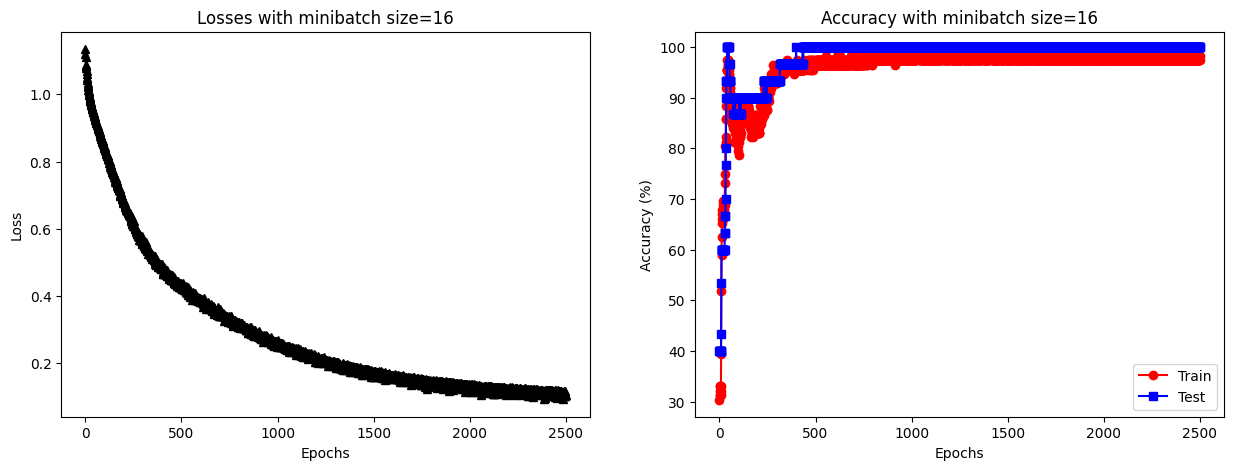

In [13]:
# plot the results
fig,ax = plt.subplots(1,2,figsize=(15,5))


ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with minibatch size=' + str(batchsize))

ax[1].plot(trainAcc,'ro-')
ax[1].plot(testAcc,'bs-')
ax[1].set_title('Accuracy with minibatch size=' + str(batchsize))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])
ax[1].set_ylim([27,103])

plt.show()

## 5. Additional Explorations

In [ ]:
# 1) Is there a relationship between the test_size parameter in train_test_split(), the batchsize parameter in DataLoader,
#    and the length of test_data? Think of your answer first, then test it in code, by creating new dataloader objects
#    with varying test_size parameters.
#    Hint: You can use the code 'len(test_data.dataset.tensors[1])', which returns the length of the labels vector.
#
# 2) Let's say you didn't care about the three types of irises; you only want a model that labels a flower as setosa or
#    "other." What would you have to change in the data and in the model to make this work?
#
# 3) In the course section "More on data," you will learn that unbalanced designs can be problematic for DL models (an
#    unbalanced design means that there is an uneven distribution of samples in different categories). Does the
#    modification in #2 produce an unbalanced design? To find out, count the number of data labels that are 0 (setosa) or
#    1 (not setosa).
#